# Data wrangling WeRateDogs DAND project

By Chenchen Li 

Apirl 24, 2018

## Introduntion

The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs

This report will describe the data wrangling effort made in the weRateDogs project.

Data wrangling consists of:

- Gathering data

- Assessing data

- Cleaning data

## Gather Data

Gathering Data for this Project composed of three pieces of data as described below:

- The WeRateDogs Twitter archive. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

- Each tweet's retweet count and favorite (i.e. "like") count at minimum, and any additional data we will find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, we will query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then we will read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [6]:
# Import the libraries that we will need in this project
import pandas as pd
import numpy as np
import datetime as dt
import time
from nltk import pos_tag
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt
import warnings

In [7]:
# Read in csv file as a Pandas DataFrame
archive = pd.read_csv('twitter-archive-enhanced.csv')
# Quick check to the file content and structure
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1910,674416750885273600,NaN,NaN,2015-12-09 02:34:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jonah. He's a Stinted Fisher Price. En...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674416750...,10,10,Jonah,None,None,None,None
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,None,None,pupper,None
972,750086836815486976,NaN,NaN,2016-07-04 22:00:12 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Spanky. He was a member of the 2002 US...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750086836...,12,10,Spanky,None,None,None,None
499,813127251579564032,NaN,NaN,2016-12-25 21:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's an anonymous doggo that appears to be v...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813127251...,11,10,None,doggo,None,None,None
1133,728751179681943552,NaN,NaN,2016-05-07 00:59:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Flurpson. He can't believe it's not bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/728751179...,10,10,Flurpson,None,None,None,None


In [8]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- The file twitter-archive-enhanced.csv successfully stored in archive data frame, it has 17 columns and 2356 entries

In [9]:
# Use requests library to download tsv file from a website
url= "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

# Read the downloaded file into a dataframe 'image_predictions'   
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
# Quick check to the file content and structure
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
970,706538006853918722,https://pbs.twimg.com/media/Cc4gjxqW4AIoThO.jpg,1,chow,0.541794,True,Pembroke,0.094918,True,Pomeranian,0.085439,True
243,670452855871037440,https://pbs.twimg.com/media/CU3tUC4WEAAoZby.jpg,1,Arctic_fox,0.188174,False,indri,0.123584,False,malamute,0.080379,True
1045,712809025985978368,https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg,1,Labrador_retriever,0.868671,True,carton,0.095095,False,pug,0.007651,True
231,670411370698022913,https://pbs.twimg.com/media/CU3HlZtW4AAezbt.jpg,1,Maltese_dog,0.584397,True,miniature_schnauzer,0.064201,True,toy_poodle,0.060868,True
1994,874057562936811520,https://pbs.twimg.com/media/DCFGtdoXkAEsqIw.jpg,1,flat-coated_retriever,0.832177,True,black-and-tan_coonhound,0.040437,True,Newfoundland,0.028228,True


In [10]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- The file image-predictions.tsv successfully downloaded and stored in image_predictions data frame, it has 12 columns and 2075 entries

In [6]:
#Credentials for accessing API
consumer_key = 'My consumer_key'
consumer_secret = 'My consumer_secret'
access_token = 'My access_token'
access_token_secret = 'My access_token_secret'




# Variables created for tweepy query
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True,  parser = tweepy.parsers.JSONParser()) 
                
                  
                

In [8]:
#Storing data from API
working =[]
not_working = []

for tweet_id in archive['tweet_id']:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
        
        favorites = page['favorite_count'] # How many favorites the tweet had
        retweets = page['retweet_count'] # Count of the retweet
        user_followers = page['user']['followers_count'] # How many followers the user had
        user_favourites = page['user']['favourites_count'] # How many favorites the user had
        date_time = page['created_at'] # The date and time of the creation
        
        working.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    
    # Catch the exceptions of the TweepError
    except Exception as e:
        #print(str(tweet_id)+ " _ " + str(e))
        not_working.append(tweet_id)

        
# lengh of the result
print("The lengh of the result", len(working))
# The tweet_id of the errors
print("The lengh of the errors", len(not_working))

Rate limit reached. Sleeping for: 718
Rate limit reached. Sleeping for: 721
The lengh of the result 2345
The lengh of the errors 11


In [ ]:
# Create DataFrames from list of dictionaries
json_tweets = pd.DataFrame(working, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])

# Save the dataFrame in file
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [11]:

# Read the saved tweet_json.txt file into a dataframe
json_tweets = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

In [12]:
json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 6 columns):
tweet_id           2411 non-null int64
favorites          2411 non-null int64
retweets           2411 non-null int64
user_followers     2411 non-null int64
user_favourites    2411 non-null int64
date_time          2411 non-null object
dtypes: int64(5), object(1)
memory usage: 113.1+ KB


## Assess Data

After gathering data, we will next assess and document them visually and programmatically for quality and tidiness issues. 

In [13]:
#disable warnings
warnings.simplefilter('ignore')

In [14]:
# View first 20 rows of archive to assess it visually
archive.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [15]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
# View descriptive statistics of twitter_archive DataFrame
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
# View first 5 rows of image_predictions DataFrame
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [18]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
# View descriptive statistics of image_predictions DataFrame
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
# View first 5 rows of json_tweets DataFrame
json_tweets.head(5)

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38963,8637,6600868,132942,2017-08-01 16:23:56
1,892177421306343426,33357,6345,6600868,132942,2017-08-01 00:17:27
2,891815181378084864,25130,4212,6600868,132942,2017-07-31 00:18:03
3,891689557279858688,42297,8757,6600869,132942,2017-07-30 15:58:51
4,891327558926688256,40461,9521,6600870,132942,2017-07-29 16:00:24


In [21]:
json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 6 columns):
tweet_id           2411 non-null int64
favorites          2411 non-null int64
retweets           2411 non-null int64
user_followers     2411 non-null int64
user_favourites    2411 non-null int64
date_time          2411 non-null object
dtypes: int64(5), object(1)
memory usage: 113.1+ KB


In [22]:
# View descriptive statistics of json_tweets DataFrame
json_tweets.describe()

,tweet_id,favorites,retweets,user_followers,user_favourites
count,2.411000e+03,2411.000000,2411.000000,2.411000e+03,2411.000000
mean,7.402061e+17,7944.361676,2972.370800,6.601197e+06,132943.404811
std,6.853420e+16,12044.110198,5003.697243,2.363565e+02,0.926982
min,6.660209e+17,0.000000,0.000000,6.600620e+06,132942.000000
25%,6.765920e+17,1473.500000,567.000000,6.600920e+06,132942.000000
50%,7.149823e+17,3436.000000,1357.000000,6.601194e+06,132944.000000
75%,7.968851e+17,9621.000000,3437.500000,6.601476e+06,132944.000000
max,8.924206e+17,143923.000000,77699.000000,6.601513e+06,132945.000000


- All the tweets in not working are retweets

In [23]:
# View rows in archive which contain '&amp;' instead of '&' in 'text' column
archive[archive.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
262,842765311967449089,NaN,NaN,2017-03-17 15:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Indie. She's not a fan of baths but she's...,NaN,NaN,NaN,"https://www.gofundme.com/get-indie-home/,https...",12,10,Indie,None,None,None,None
273,840728873075638272,NaN,NaN,2017-03-12 00:59:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Pipsy. He is a fluffbal...,6.671522e+17,4.196984e+09,2015-11-19 01:27:25 +0000,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
320,834458053273591808,NaN,NaN,2017-02-22 17:41:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Chester (bottom) &amp; Harold (top). They...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834458053...,12,10,Chester,None,None,None,None
461,817536400337801217,NaN,NaN,2017-01-07 01:00:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Eugene &amp; Patti Melt. No matte...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817536400...,12,10,Eugene,None,None,None,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409...,9,10,Beau,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
799,772826264096874500,NaN,NaN,2016-09-05 15:58:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Roosevelt. He's preparing for takeoff. Ma...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772826264...,11,10,Roosevelt,None,None,None,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo,None,pupper,None
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilli Bee &amp; Honey Bear. Unfortunat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758854675...,11,10,Lilli,None,None,None,None
976,750026558547456000,NaN,NaN,2016-07-04 18:00:41 +0000,"<a href=""https://about.twitter.com/products/tw...",Meet Jax &amp; Jil. Jil is yelling the pledge ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750026558...,10,10,Jax,None,None,None,None


In [24]:
# Sort values of 'name' column alphabetically - lowercase values appear at the bottom
archive.name.sort_values()

1035            Abby
1021            Abby
938              Ace
1933            Acro
1327           Adele
1934           Aiden
77               Aja
480            Akumi
820               Al
875           Albert
1954          Albert
144            Albus
412            Albus
1115         Aldrick
2046       Alejandro
374        Alexander
1189    Alexanderson
486              Alf
2238           Alfie
661            Alfie
367            Alfie
1616           Alfie
858            Alfie
51              Alfy
201            Alice
1701           Alice
1495           Amber
1334         Ambrose
2078             Amy
2195          Amélie
            ...     
852               my
988              not
335              not
1747      officially
1206             old
993              one
1936             one
924              one
369              one
2326           quite
169            quite
118            quite
193            quite
2030           space
22              such
2345             the
2346         

In [25]:
# View number of entries for each source
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [26]:
# View rows where the value of 'name' is lowercase - indicates that it is not an actual name
archive.loc[(archive['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None


In [27]:
# View rows where the value of 'name' is lowercase and the word 'named' appears in the 'text' column which indicates 
# there is an actual dog name in the text
archive.loc[(archive['name'].str.islower()) & (archive['text'].str.contains('named'))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1853,675706639471788032,NaN,NaN,2015-12-12 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sizzlin Menorah spaniel from Brookly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675706639...,10,10,a,None,None,None,None
1955,673636718965334016,NaN,NaN,2015-12-06 22:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Lofted Aphrodisiac Terrier named Kip...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673636718...,10,10,a,None,None,None,None
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150...,11,10,a,None,None,None,None
2066,671147085991960577,NaN,NaN,2015-11-30 02:01:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Helvetica Listerine named Rufus. Thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085...,9,10,a,None,None,None,None
2116,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002...,9,10,a,None,None,None,None
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874...,9,10,a,None,None,None,None
2128,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Speckled Cauliflower Yosemite named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360...,9,10,a,None,None,None,None
2146,669923323644657664,NaN,NaN,2015-11-26 16:59:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a spotted Lipitor Rumpelstiltskin name...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669923323...,10,10,a,None,None,None,None
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669564461...,10,10,a,None,None,None,None
2191,668955713004314625,NaN,NaN,2015-11-24 00:54:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Slovakian Helter Skelter Feta named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668955713...,10,10,a,None,None,None,None


## Quality

### archive dataset

- Dataset contains retweets, we only want original ratings (no retweets) that have images
- Some Tweets with no images
- Invalid names i.e 'None', 'a', 'an' in 'name' column
- Erroneous datatypes (timestamp, source, dog stages, tweet_id, in_reply_to_status_id, in_reply_to_user_id)
- In several columns null objects are non-null (None to NaN)
- The numerator and denominator columns have invalid values
- Tweet ID# 810984652412424192 doesn't contain a rating
- Tweet with more than one #/# sometimes have the first occurence erroneously used for the rating numerators and denominators

### image_predictions dataset

- Missing values from images dataset (2075 rows instead of 2356)
- Some tweets are have 2 different tweet_id one redirect to the other

## Tidiness

- In 'archive', the columns 'retweeted_status_id' 'retweeted_status_user_id' and 'retweeted_status_timestamp' are useless after   we get rid of retweets.
- Dog "stage" variable in four columns: doggo, floofer, pupper, puppo
- 'json_tweets' and 'image_predictions' should be joined into 'archive'

# Clean Data

In [28]:
# Since we want to create one high quality and tidy master DataFrame
# we will start by merging our dataframe in one
# the we save the result in file as backup
df_master = pd.merge(archive, image_predictions, how = 'left', on = ['tweet_id'] )
df_master = pd.merge(df_master, json_tweets, how = 'left', on = ['tweet_id'])
df_master.to_csv('df_master.csv', encoding = 'utf-8')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2422 entries, 0 to 2421
Data columns (total 33 columns):
tweet_id                      2422 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2422 non-null object
source                        2422 non-null object
text                          2422 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2363 non-null object
rating_numerator              2422 non-null int64
rating_denominator            2422 non-null int64
name                          2422 non-null object
doggo                         2422 non-null object
floofer                       2422 non-null object
pupper                        2422 non-null object
puppo                         2422 non-null object
jpg_url                       21

###  Define

- Remove retweets.
- Remove rows where there are no images (expanded_urls).
- Remove duplicated tweet_id

###  Code

In [29]:
# Delete the retweets
df_master_clean = df_master[df_master['retweeted_status_id'].isnull()]
# Delete duplicated tweet_id
df_master_clean = df_master_clean.drop_duplicates()
# Delete tweets with no pictures
df_master_clean = df_master_clean.dropna(subset = ['jpg_url'])

### Test

In [30]:
# test
len(df_master_clean)
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 33 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
jpg_url                       1994 non

### Define

- Remove column 'date_time' which has the same values 'timestamp' column

### Code

In [31]:
# drop columns related to retweets
columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
df_master_clean = df_master_clean.drop(columns, axis=1)

# Delete column date_time 
df_master_clean = df_master_clean.drop('date_time', 1)



### Test

In [32]:
# test
list(df_master_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites']

### Define

- Fill empty names and Correct the bad ones

### Code

In [33]:
# Save locations where 'name' column is lowercase, lowercase and 'text' column contains 'named' and 
# lowercase and 'text' column contains the words 'name is'
named_to_replace = df_master_clean.loc[(df_master_clean['name'].str.islower()) & 
                                       (df_master_clean['text'].str.contains('named'))]

name_is_to_replace = df_master_clean.loc[(df_master_clean['name'].str.islower()) & 
                                         (df_master_clean['text'].str.contains('name is'))]

not_named_to_replace = df_master_clean.loc[(df_master_clean['name'].str.islower())]

# Save these locations as lists
named_to_replace_list = named_to_replace['text'].tolist()
name_is_to_replace_list = name_is_to_replace['text'].tolist()
not_named_to_replace_list = not_named_to_replace['text'].tolist()

# For loop to iterate through locations where name is lowercase and the words 'named' appear in 'text'
# and set the 'name' value to be the word that appears after 'named'
for entry in named_to_replace_list:
    mask = df_master_clean.text == entry
    name_column = 'name'
    df_master_clean.loc[mask, name_column] = re.findall(r"named\s(\w+)", entry)

# For loop to iterate through locations where name is lowercase and the words 'name is' appear in 'text' and set the 'name' 
# value to be the word that appears after 'name is'    
for entry in name_is_to_replace_list:
    mask = df_master_clean.text == entry
    name_column = 'name'
    df_master_clean.loc[mask, name_column] = re.findall(r"name is\s(\w+)", entry)    

# For loop to iterate through locations where name is lowercase and replace the name value with the word "None"
for entry in not_named_to_replace_list:
    mask = df_master_clean.text == entry
    name_column = 'name'
    df_master_clean.loc[mask, name_column] = "None"

# Replace the occurence of "O" with "O'Malley"
df_master_clean.name = df_master_clean.name.replace("O", "O'Malley")

### Test

In [34]:
df_master_clean.name.sort_values()

1021            Abby
1035            Abby
938              Ace
1933            Acro
1327           Adele
1934           Aiden
77               Aja
480            Akumi
820               Al
875           Albert
1954          Albert
144            Albus
412            Albus
1115         Aldrick
2046       Alejandro
374        Alexander
1189    Alexanderson
486              Alf
367            Alfie
858            Alfie
1616           Alfie
2238           Alfie
51              Alfy
201            Alice
1701           Alice
1495           Amber
1334         Ambrose
2078             Amy
2195          Amélie
780           Anakin
            ...     
927           Winnie
263           Winnie
407          Winston
1243         Winston
986          Winston
816          Winston
1829         Winston
280          Winston
559          Winston
2133         Winston
877           Wishes
174            Wyatt
410            Wyatt
1451           Wyatt
1378            Yoda
43              Yogi
622          

### Define
- Change missing values in 'name' from 'None' to NaN 

### code

In [35]:
df_master_clean['name'] = df_master_clean['name'].replace('None', np.NaN)

### Test

In [36]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1350 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                    

### Define

- Melt the individual dog stage columns ('doggo', 'floofer', 'pupper' and 'puppo' columns) into a new column 'dog_stage'.

### code

In [37]:
# Select the columns to melt and to remain
columns_to_melt = ['doggo', 'floofer', 'pupper', 'puppo']
columns_to_stay = [x for x in df_master_clean.columns.tolist() if x not in columns_to_melt]

# Mlet the the columns into values
df_master_clean = pd.melt(df_master_clean, id_vars = columns_to_stay, value_vars = columns_to_melt, 
                        var_name = 'stages', value_name = 'dog_stage')


###  Test

In [38]:
# Delete column 'stages'
df_master_clean = df_master_clean.drop('stages', 1)

# remove duplicate values based on 'dog_stage' values
df_master_clean = df_master_clean.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')
print(df_master_clean.dog_stage.value_counts())
print(len(df_master_clean))

None       1688
pupper      212
doggo        63
puppo        23
floofer       8
Name: dog_stage, dtype: int64
1994


### Define

- Get rid of image prediction columns

### Code

In [39]:
# Store the fisrt true algorithm with it's level of confidence
prediction_algorithm = []
confidence_level = []

# Get_prediction_confidence function:
# search the first true algorithm and append it to a list with it's level of confidence
# if flase prediction_algorthm will have a value of NaN
def get_prediction_confidence(dataframe):
    if dataframe['p1_dog'] == True:
        prediction_algorithm.append(dataframe['p1'])
        confidence_level.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        prediction_algorithm.append(dataframe['p2'])
        confidence_level.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        prediction_algorithm.append(dataframe['p3'])
        confidence_level.append(dataframe['p3_conf'])
    else:
        prediction_algorithm.append('NaN')
        confidence_level.append(0)

df_master_clean.apply(get_prediction_confidence, axis=1)
df_master_clean['prediction_algorithm'] = prediction_algorithm
df_master_clean['confidence_level'] = confidence_level

# Delete the columns of image prediction information
df_master_clean = df_master_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)


### Test

In [40]:
# Test
list(df_master_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'jpg_url',
 'favorites',
 'retweets',
 'user_followers',
 'user_favourites',
 'dog_stage',
 'prediction_algorithm',
 'confidence_level']

### Define

- Convert the null values to None type

### Code

In [41]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 1918 to 6764
Data columns (total 18 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1350 non-null object
jpg_url                  1994 non-null object
favorites                1994 non-null float64
retweets                 1994 non-null float64
user_followers           1994 non-null float64
user_favourites          1994 non-null float64
dog_stage                1994 non-null object
prediction_algorithm     1994 non-null object
confidence_level         1994 non-null float64
dtypes: float64(7), int64(3), object(8)
memory usage: 296.0+ K

In [42]:
df_master_clean.loc[df_master_clean['prediction_algorithm'] == 'NaN', 'prediction_algorithm'] = None
df_master_clean.loc[df_master_clean['name'] == 'NaN', 'name'] = None

### Test

In [43]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 1918 to 6764
Data columns (total 18 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1350 non-null object
jpg_url                  1994 non-null object
favorites                1994 non-null float64
retweets                 1994 non-null float64
user_followers           1994 non-null float64
user_favourites          1994 non-null float64
dog_stage                1994 non-null object
prediction_algorithm     1686 non-null object
confidence_level         1994 non-null float64
dtypes: float64(7), int64(3), object(8)
memory usage: 296.0+ K

### Define

- Convert each column to its appropriate type

### Code

In [44]:
df_master_clean.dtypes

tweet_id                   int64
in_reply_to_status_id    float64
in_reply_to_user_id      float64
timestamp                 object
source                    object
text                      object
expanded_urls             object
rating_numerator           int64
rating_denominator         int64
name                      object
jpg_url                   object
favorites                float64
retweets                 float64
user_followers           float64
user_favourites          float64
dog_stage                 object
prediction_algorithm      object
confidence_level         float64
dtype: object

In [45]:
df_master_clean['tweet_id'] = df_master_clean['tweet_id'].astype(object)
df_master_clean['timestamp'] = pd.to_datetime(df_master_clean['timestamp'])
df_master_clean['source'] = df_master_clean['source'].astype('category')
df_master_clean['favorites'] = df_master_clean['favorites'].astype(int)
df_master_clean['user_followers'] = df_master_clean['user_followers'].astype(int)
df_master_clean['dog_stage'] = df_master_clean['dog_stage'].astype('category')
df_master_clean['rating_numerator'] = df_master_clean['rating_numerator'].astype(float)
df_master_clean['rating_denominator'] = df_master_clean['rating_denominator'].astype(float)

### Test

In [46]:
df_master_clean.dtypes

tweet_id                         object
in_reply_to_status_id           float64
in_reply_to_user_id             float64
timestamp                datetime64[ns]
source                         category
text                             object
expanded_urls                    object
rating_numerator                float64
rating_denominator              float64
name                             object
jpg_url                          object
favorites                         int64
retweets                        float64
user_followers                    int64
user_favourites                 float64
dog_stage                      category
prediction_algorithm             object
confidence_level                float64
dtype: object

## Store

- Store the cleaned DataFrame in a CSV file names as 'twitter_archive_master.csv'

In [47]:
# Store the clean DataFrame in a CSV file
df_master_clean.to_csv('twitter_archive_master.csv')

In [48]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 19 columns):
Unnamed: 0               1994 non-null int64
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null float64
rating_denominator       1994 non-null float64
name                     1350 non-null object
jpg_url                  1994 non-null object
favorites                1994 non-null int64
retweets                 1994 non-null float64
user_followers           1994 non-null int64
user_favourites          1994 non-null float64
dog_stage                1994 non-null object
prediction_algorithm     1686 non-null object
confidence_level         1994 non-null float64
dtypes: float64(7), 

## Analyze

In [49]:
import seaborn as sns

In [50]:
# Set the index to be the timestamp so time is displayed properly in plots
twitter_archive_master.set_index('timestamp', inplace=True)

In [51]:
#Rename columns to be more expressive
twitter_archive_master = twitter_archive_master.rename(columns = {'prediction_algorithm' : 'dog_breed'})

### Favorites and Retweets

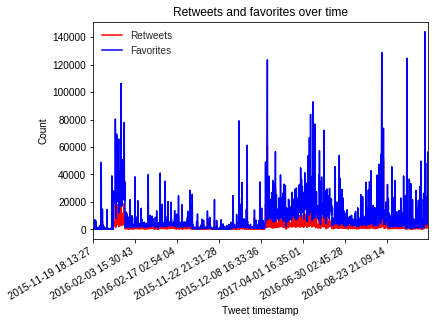

In [52]:
fig1 = twitter_archive_master['retweets'].plot(color = 'red', label='Retweets')
fig2 = twitter_archive_master['favorites'].plot(color = 'blue', label='Favorites')
plt.style.use('seaborn-darkgrid')
plt.legend(loc='upper left')
plt.xlabel('Tweet timestamp')
plt.ylabel('Count')
plt.title('Retweets and favorites over time')
plt.savefig('retweets_favorites.png')

for label in fig1.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')

plt.show()

Text(0.5,1,'Retweets and favorites Scatter plot')

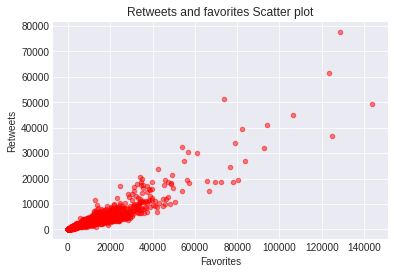

In [53]:
twitter_archive_master.plot(kind = 'scatter', x = 'favorites', y = 'retweets', alpha = 0.5, color = 'red')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')

- The correlation map shows the positive correlation between the count of retweet and the count of favorites.

### Rating System

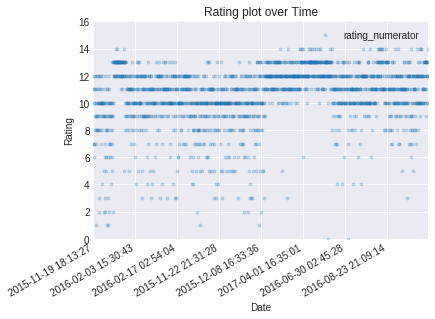

In [54]:
# Our range will be [0,16] taking of the two ouliers (1776 and 420)
fig = twitter_archive_master.plot(y ='rating_numerator', ylim=[0,16], style = '.', alpha = .2)
plt.title('Rating plot over Time')
plt.xlabel('Date')
plt.ylabel('Rating')

for label in fig.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')

### Famous dog Breeds

In [55]:
#Rename columns to be more expressive
twitter_archive_master = twitter_archive_master.rename(columns = {'prediction_algorithm' : 'dog_breed'})

Text(0,0.5,'dog_breed')

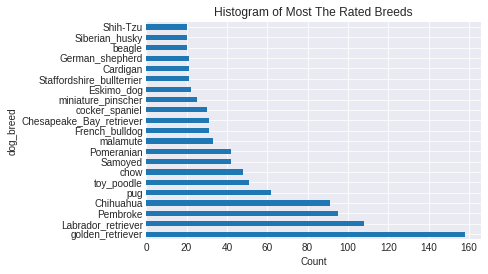

In [56]:
# Subset the data on the most owned (>= 20)
df_by_breed = twitter_archive_master.groupby('dog_breed').filter(lambda x: len(x) >= 20)

df_by_breed['dog_breed'].value_counts().plot(kind = 'barh')
plt.title('Histogram of Most The Rated Breeds')
plt.xlabel('Count')
plt.ylabel('dog_breed')

- Top two famous breeds are : Golden_retriver and Labrador_retriver.

### Dog Stages Distribution

(-1.288268191449591,
 1.2310305760057396,
 -1.2401381220397572,
 1.2110819987279693)

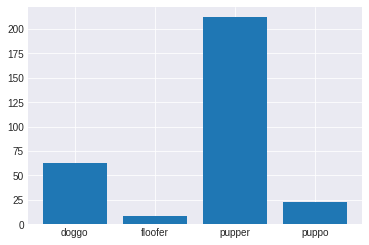

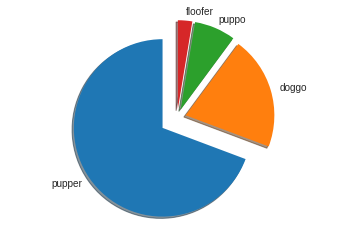

In [57]:
dog_stage_count = list(twitter_archive_master[twitter_archive_master['dog_stage'] != 'None']['dog_stage'].value_counts())[0:4]
dog_stages = twitter_archive_master[twitter_archive_master['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

plt.bar(dog_stages, dog_stage_count)

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

- Among the 4 dog stages, pupper has the biggest frequency.